# Exercises

In [1]:
import scipy
import seaborn
import numpy as np
import matplotlib.pyplot as plt

# Exercise 1

In [2]:
alpha = 5
beta = 2
n = 10
k = 8
sigma = 0.2

a) Proposal Distribution

In [3]:
def propose_jump(pi, sigma, size = 1):
    result = scipy.stats.norm.rvs(
        loc = pi, # mean
        scale = sigma, # standard deviation
        size = size
    )
    return result if size > 1 else result.item()


def normalize(values: list):
    array = np.array(values, dtype = float)
    return (array - array.min()) / (array.max() - array.min())

b) Random walk

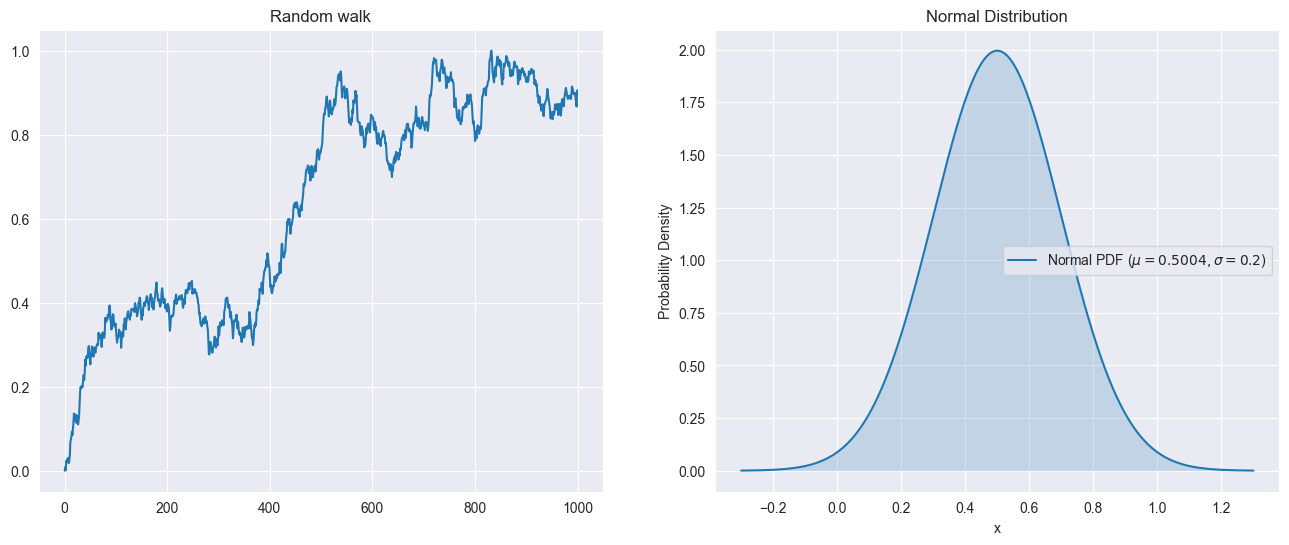

In [4]:
def plot_normal_distribution(ax, mean, sigma):
    # Generate x values around the mean
    x = np.linspace(mean - 4 * sigma, mean + 4 * sigma, 1000)

    # Compute the PDF
    y = scipy.stats.norm.pdf(x, loc = mean, scale = sigma)
    ax.plot(x, y, label=f'Normal PDF ($\mu={mean:.4f}, \sigma={sigma}$)')
    ax.fill_between(x, y, alpha=0.2)
    ax.set_title("Normal Distribution")
    ax.set_xlabel("x")
    ax.set_ylabel("Probability Density")
    ax.grid(True)
    ax.legend()

start = np.random.rand()

steps = []
for i in range(1000):
    pi = start
    if i > 0:
        pi = steps[i - 1]

    steps.append(propose_jump(pi, sigma))

walk = normalize(steps)

fig = plt.figure(figsize = (16, 6))

ax = fig.add_subplot(1, 2, 1)
ax.set_title('Random walk')
ax.grid(True)
ax.plot(walk)

ax = fig.add_subplot(1, 2, 2)
plot_normal_distribution(ax, start, sigma)


c) Jump decision

In [5]:
def acceptance_propability(pi, pi2, alpha, beta, n, k):
    numerator = scipy.stats.beta.pdf(x = pi2, a = alpha, b = beta) * scipy.stats.binom.pmf(k = k, n = n, p = pi2)
    denominator = scipy.stats.beta.pdf(x = pi, a = alpha, b = beta) * scipy.stats.binom.pmf(k = k, n = n, p = pi)
    return min(1, numerator / denominator)

def decide(pi, pi2, alpha, beta, n, k):
    if pi2 > 1 or pi2 < 0:
        return pi

    p = np.random.rand()
    acceptance_p = acceptance_propability(pi, pi2, alpha, beta, n, k)

    if p <= acceptance_p:
        return pi2
    else:
        return pi

d) Single-chain Metropolis algorithm

In [6]:
def metropolis_chain(n_steps, alpha, beta, n, k, sigma):
    chain = np.zeros(n_steps)
    pi = np.random.rand()

    for i in range(n_steps):
        pi2 = propose_jump(pi, sigma)
        pi = decide(pi, pi2, alpha, beta, n, k)
        chain[i] = pi

    return np.array(chain)


def plot_trace(pi, title: str = "Trace plot of π", ax: plt.Axes = None):
    ax = plt.subplots(figsize=(10, 4))[1] if ax is None else ax

    if pi.ndim == 2:
        for i, chain in enumerate(pi):
            ax.plot(chain, alpha=0.7, label=f'Chain {i+1}')
        ax.legend()
    else:
        ax.plot(pi)

    ax.set_title(title)
    ax.set_xlabel("step")
    ax.set_ylabel("π")
    ax.grid(True)

e) Verification: Hyperparameter tuning

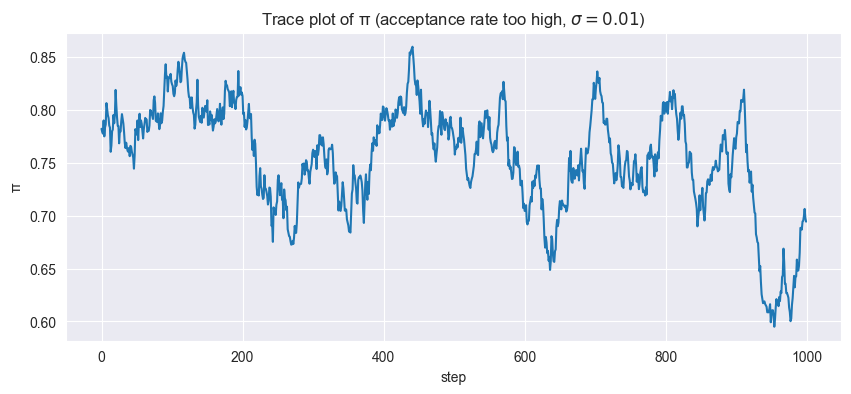

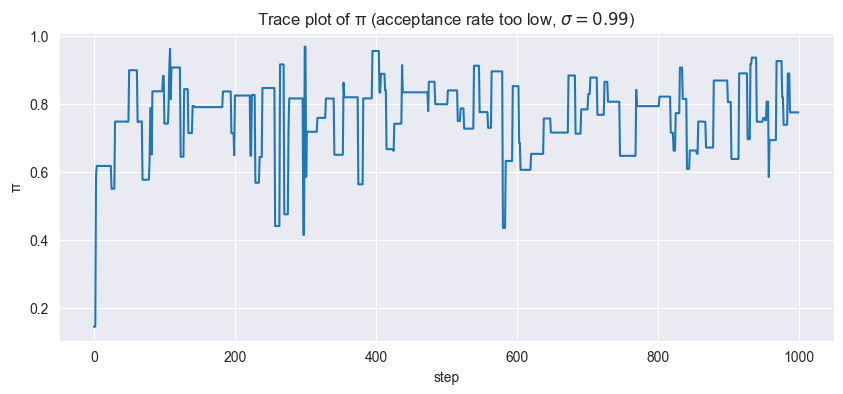

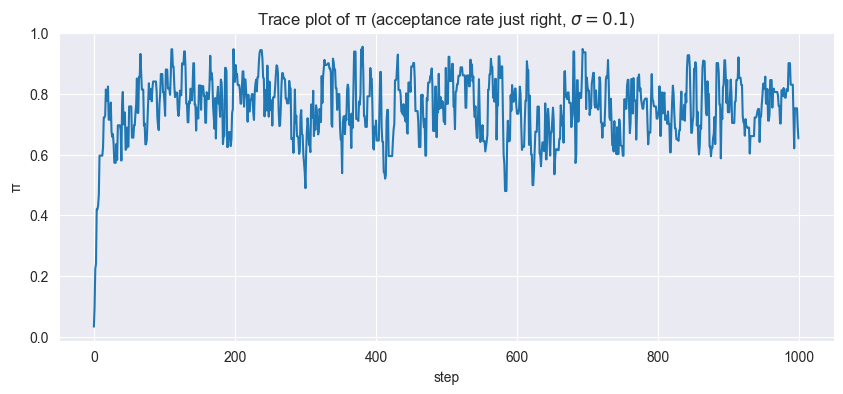

In [7]:
plot_trace(
    metropolis_chain(
        n_steps = 1000,
        alpha = alpha,
        beta = beta,
        n = n,
        k = k,
        sigma = 0.01
    ),
    title = "Trace plot of π (acceptance rate too high, $\sigma = 0.01$)"
)

plot_trace(
    metropolis_chain(
        n_steps = 1000,
        alpha = alpha,
        beta = beta,
        n = n,
        k = k,
        sigma = 0.99
    ),
    title = "Trace plot of π (acceptance rate too low, $\sigma = 0.99$)"
)

plot_trace(
    metropolis_chain(
        n_steps = 1000,
        alpha = alpha,
        beta = beta,
        n = n,
        k = k,
        sigma = 0.1
    ),
    title = "Trace plot of π (acceptance rate just right, $\sigma = 0.1$)"
)


e) Verification: Visualize distribution

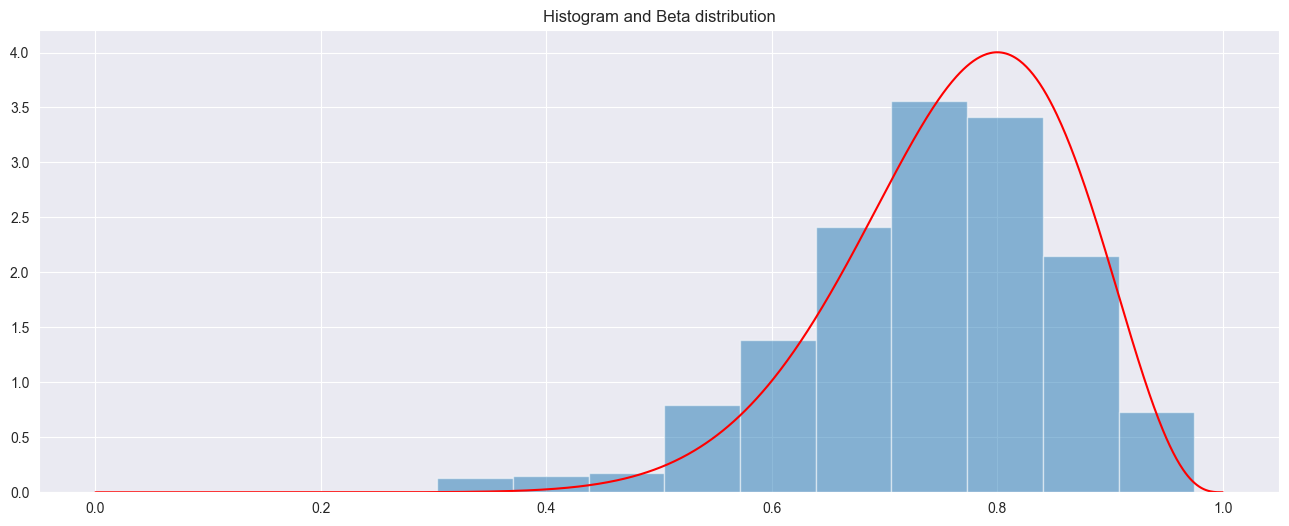

In [8]:
chain = metropolis_chain(
    n_steps = 1000,
    alpha = alpha,
    beta = beta,
    n = n,
    k = k,
    sigma = 0.1
)

def plot_hist_and_beta_distribution(chain, alpha, beta, n, k, title: str = "Histogram and Beta distribution", ax: plt.Axes = None):
    ax = plt.subplots(figsize=(16, 6))[1] if ax is None else ax
    ax.hist(chain, density = True, alpha = 0.5)

    beta_distribution_samples = np.linspace(0, 1, 1000)
    ax.plot(beta_distribution_samples, scipy.stats.beta.pdf(beta_distribution_samples, alpha + k, beta + n - k), color = 'red')
    ax.set_title(title)

plot_hist_and_beta_distribution(chain, alpha, beta, n, k)

f) Playing around

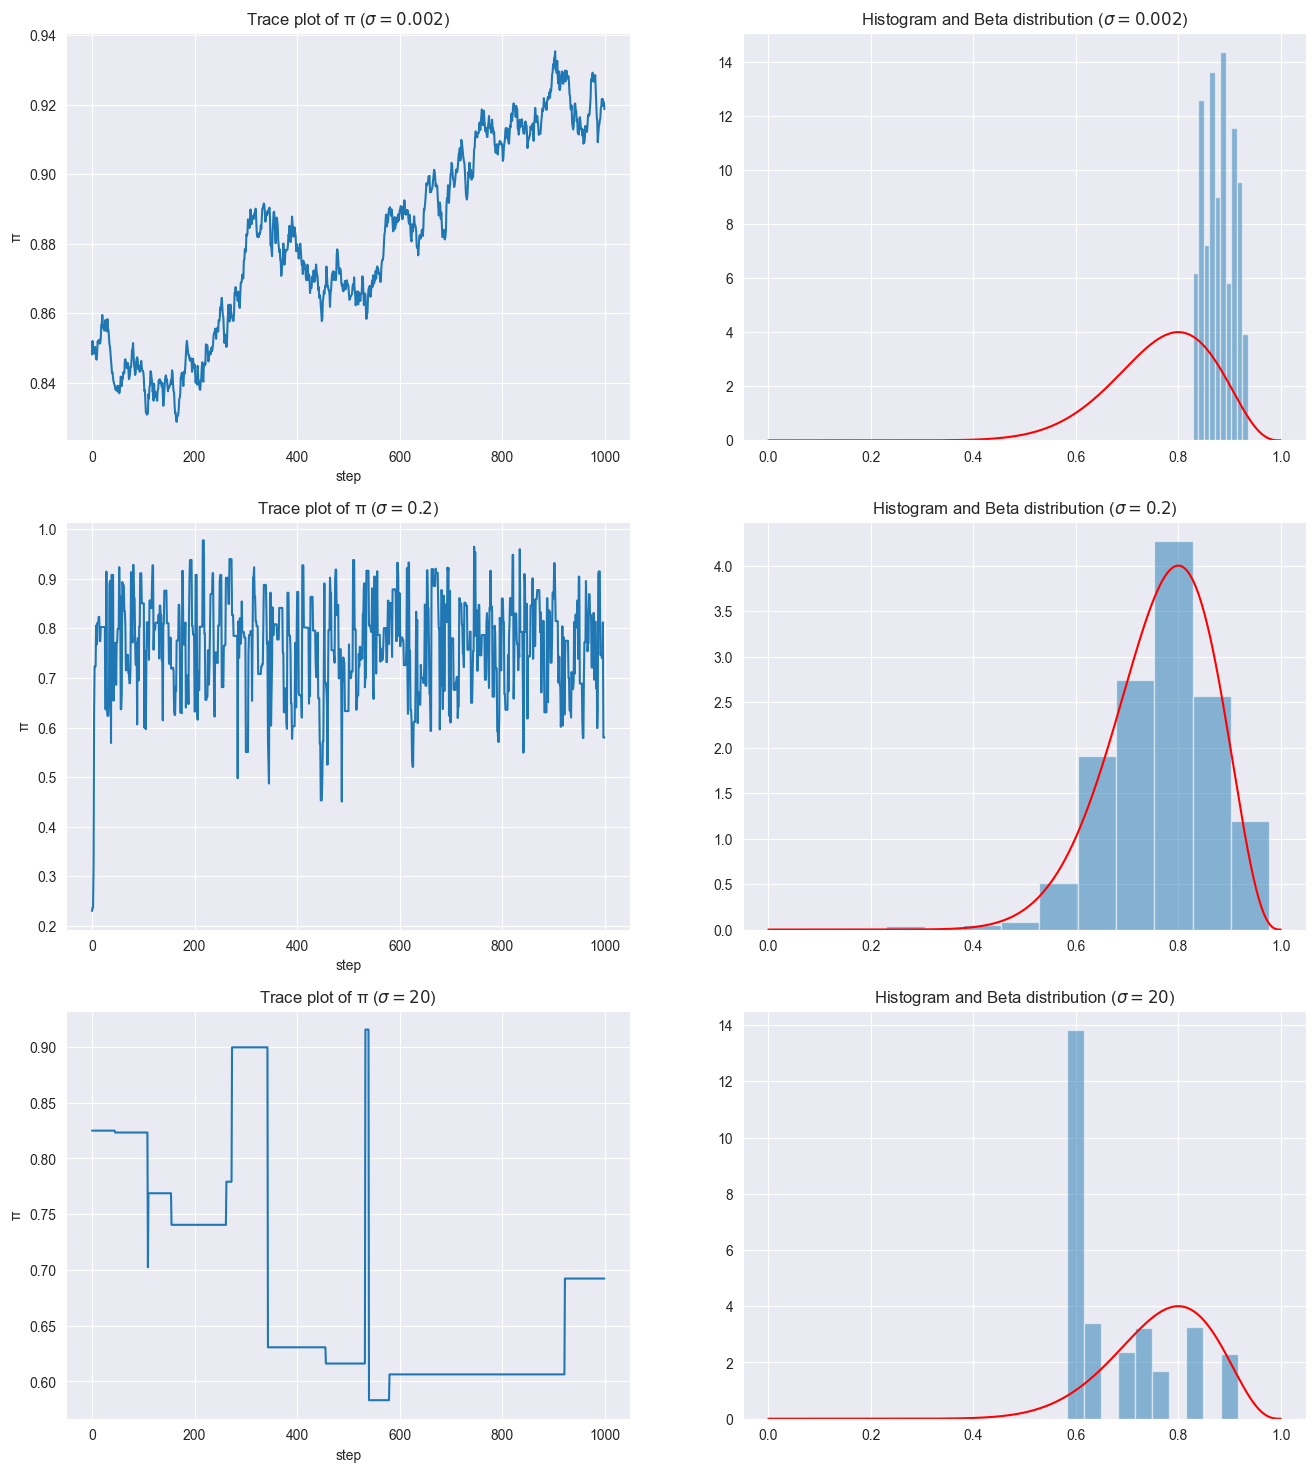

In [9]:
sigmas = [0.002, 0.2, 20]

plot_nrows = len(sigmas)
fig = plt.figure(figsize = (16, 6 * plot_nrows))

for i, sigma in enumerate(sigmas):
    chain = metropolis_chain(
            n_steps = 1000,
            alpha = alpha,
            beta = beta,
            n = n,
            k = k,
            sigma = sigma
        )

    ax = fig.add_subplot(plot_nrows, 2, 2*i + 1)
    plot_trace(chain, title = f"Trace plot of π ($\sigma = {sigma}$)", ax = ax)

    ax = fig.add_subplot(plot_nrows, 2, 2*i + 2)
    plot_hist_and_beta_distribution(chain, alpha, beta, n, k, title = f"Histogram and Beta distribution ($\sigma = {sigma}$)", ax = ax)


if $\sigma$ is too small, the chain explores only a small part of the parameter space! Acceptance rate is very high because chain always climbs up towards the mode with very small steps. However it barely reaches it.

if $\sigma$ is too large, the chain is mostly stuck at the same point and most of the proposals are rejected. Because of this, we only get a few independent samples and the density is concentrated and exaggerated around the points where the chain was stuck.


# Exercise 2

a) Multiple Chains

In [10]:
def metropolis(n_chains, n_steps, alpha, beta, n, k, sigma):
    chains = np.zeros((n_chains, n_steps))
    for i in range(n_chains):
        chains[i] = metropolis_chain(n_steps, alpha, beta, n, k, sigma)
    return chains

b) Trace plots

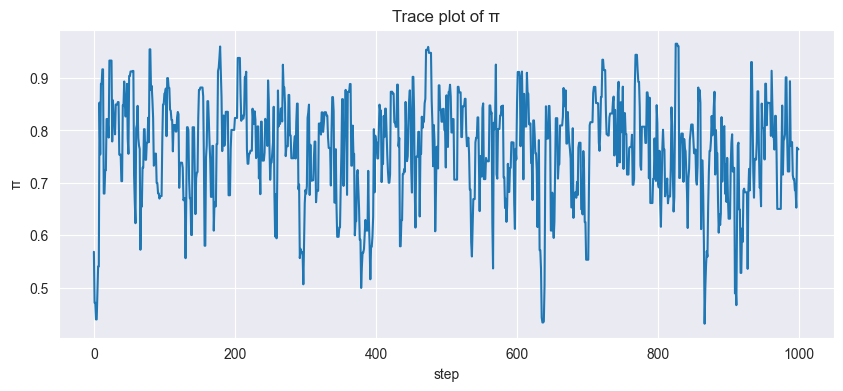

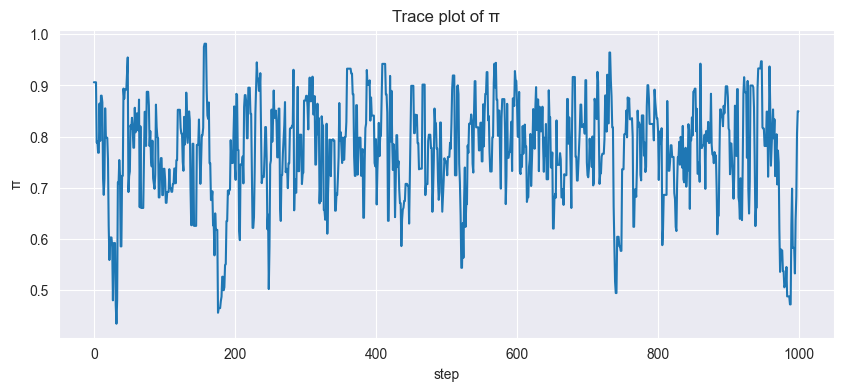

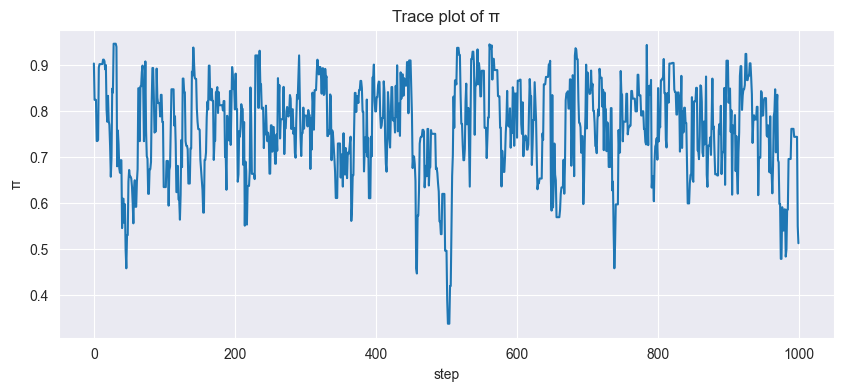

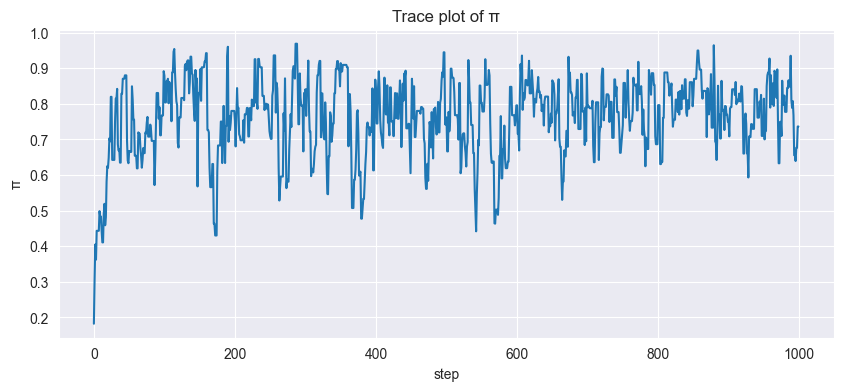

In [11]:
n_chains = 4
sigma = 0.1

chains = metropolis(n_chains, 1000, alpha, beta, n, k, sigma)
for chain in chains:
    plot_trace(chain)

Things look good: The 4 chains mix nicely.

Text(0.5, 1.0, 'Kernel Density Estimate of π')

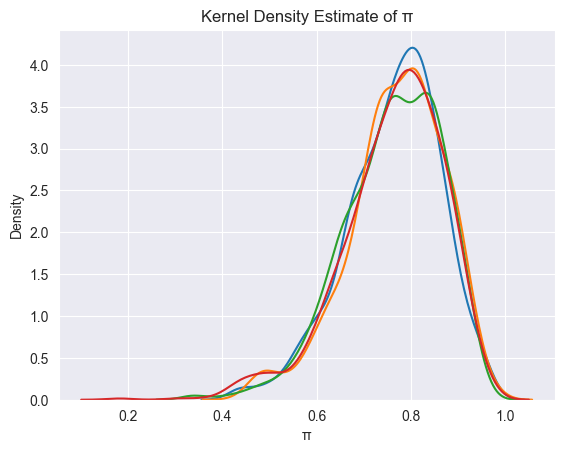

In [12]:
for chain in chains:
    seaborn.kdeplot(chain, legend = False)
plt.xlabel("π")
plt.ylabel("Density")
plt.title("Kernel Density Estimate of π")

The kernel density estimate shows a surface which seems to be rather similar to the distribution we are looking for.

**For too small sigma:**

Values tend to stay in the same area and don't really mix - which means we don't receive a meaningful distriution:
Chains have not converged yet and explore different regions of the parameter space.

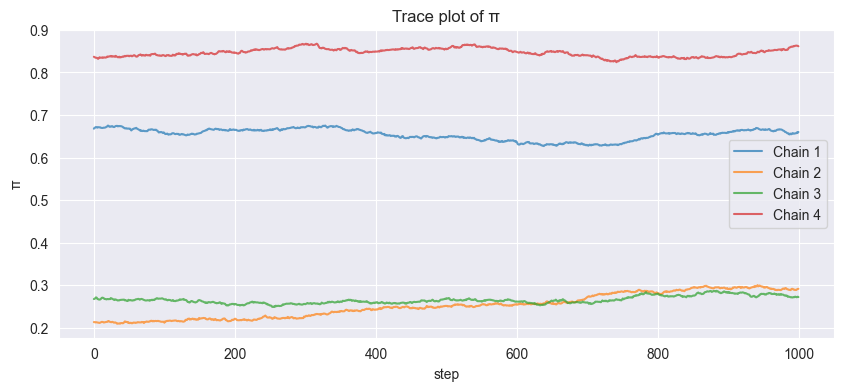

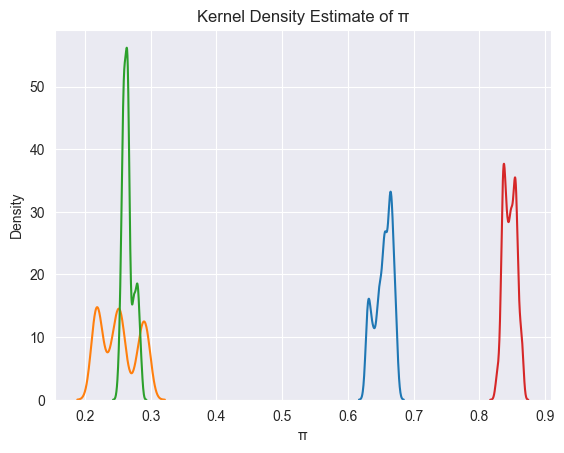

In [13]:
n_chains = 4
sigma = 0.001

chains = metropolis(n_chains, 1000, alpha, beta, n, k, sigma)
plot_trace(chains)
plt.show()

for chain in chains:
    seaborn.kdeplot(chain, legend = False)
plt.xlabel("π")
plt.ylabel("Density")
plt.title("Kernel Density Estimate of π")
plt.show()

**For too large sigma:**

the different chains don't mix are reduced to just a few different values. So we don't really receive a meaningful distribution: Chains have not coverged - density plot is misleading, chains are stuck at single points.

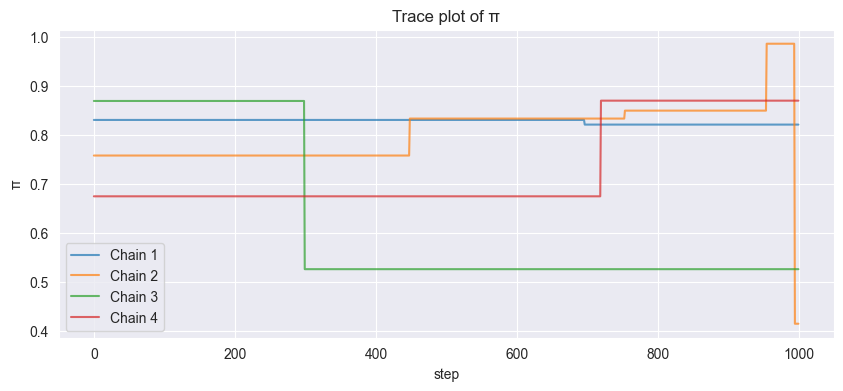

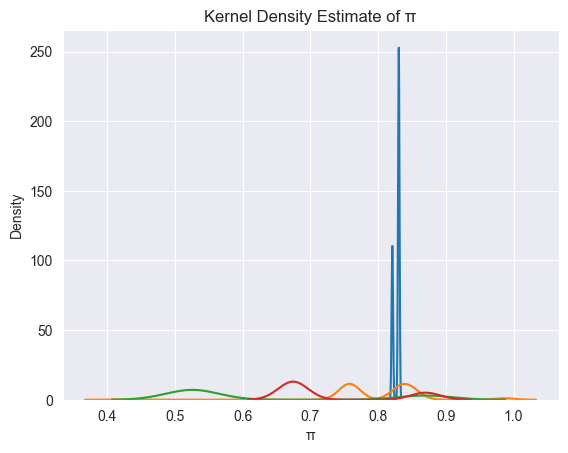

In [14]:
n_chains = 4
sigma = 100

chains = metropolis(n_chains, 1000, alpha, beta, n, k, sigma)
plot_trace(chains)
plt.show()

for chain in chains:
    seaborn.kdeplot(chain, legend = False)
plt.xlabel("π")
plt.ylabel("Density")
plt.title("Kernel Density Estimate of π")
plt.show()

d) $\hat{R}$

In [15]:
def compute_rhat(chains):
    variance_total = np.var(chains, ddof = 1)
    variance_per_chain = np.var(chains, axis = 1, ddof = 1)
    mean_variance_per_chain = np.mean(variance_per_chain)

    return np.sqrt(variance_total / mean_variance_per_chain)

In [16]:
n_chains = 4
sigma = 0.1
chains = metropolis(n_chains, 1000, alpha, beta, n, k, sigma)

compute_rhat(chains)

1.0008672816494895

**$\hat{R}$ for too small sigma:**

In [17]:
sigmas = [0.001, 0.01]

for sigma in sigmas:
    rhat = compute_rhat(metropolis(4, 1000, alpha, beta, n, k, sigma))
    print(f"sigma = {sigma}, Rhat = {rhat:.4f}")

sigma = 0.001, Rhat = 15.1843
sigma = 0.01, Rhat = 1.3704


**$\hat{R}$ for too large sigma:**

In [18]:
sigmas = [0.5, 1.0, 100]

for sigma in sigmas:
    rhat = compute_rhat(metropolis(4, 1000, alpha, beta, n, k, sigma))
    print(f"sigma = {sigma}, Rhat = {rhat:.4f}")

sigma = 0.5, Rhat = 1.0013
sigma = 1.0, Rhat = 1.0090
sigma = 100, Rhat = 1.2359


$\hat{R}$ doesn't seem to be enough to distuingish good from bad chains.

e) Burn-in phase

The values from the burn-in phase are not relevant for the beta-binominal problem. Given we sample enough data points, the burn in phase will be neglectable. However, if we don't sample as many data points, we need to be aware that the burn-in phase might skew our resulting distribution and we might consider removing the first n samples.

# Exercise 3


a) Reproduce the results from previous exercise with PyMC

Looking at the code, the issue is likely related to PyMC's sampler requiring a C compiler. The error occurs because PyMC needs to compile C code for efficient sampling, but either the compiler is missing or there's a configuration issue.

The solution is to use a different sampler that doesn't require C compilation. You can use the `nuts_sampler="numpyro"` argument which uses JAX/NumPyro as a backend instead of the default C-based sampler.



In [19]:
import pymc as pm
import arviz as az

# Disable C compilation by using the Python-only mode:
import pytensor
pytensor.config.cxx = ""

with pm.Model() as beta_binom_model:
    pi = pm.Beta('pi', alpha=alpha, beta=beta)
    y = pm.Binomial('y', n=n, p=pi, observed=k)
    trace = pm.sample(1000)

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi]


/Users/marbetschar/Development/marbetschar/notes/.venv/lib/python3.9/site-packages/pytensor/scalar/basic.py:2006: RuntimeWarning: invalid value encountered in divide
  return x / y
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


b)

In [20]:
trace


Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [21]:
trace.posterior.pi

<xarray.DataArray 'pi' (chain: 4, draw: 1000)> Size: 32kB
array([[0.74905612, 0.78507516, 0.81968264, ..., 0.70603414, 0.70603414,
        0.84068837],
       [0.69996256, 0.69996256, 0.80170911, ..., 0.8492316 , 0.9574433 ,
        0.94126818],
       [0.97930914, 0.95170406, 0.85949623, ..., 0.79887407, 0.77225564,
        0.65570754],
       [0.72256922, 0.634444  , 0.72561472, ..., 0.89231344, 0.56221636,
        0.89163142]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 8kB 0 1 2 3 4 5 6 7 ... 993 994 995 996 997 998 999

<Axes: title={'center': 'pi'}, xlabel='Quantile', ylabel='ESS for small intervals'>

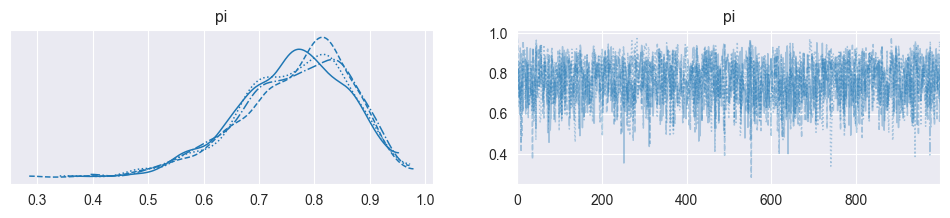

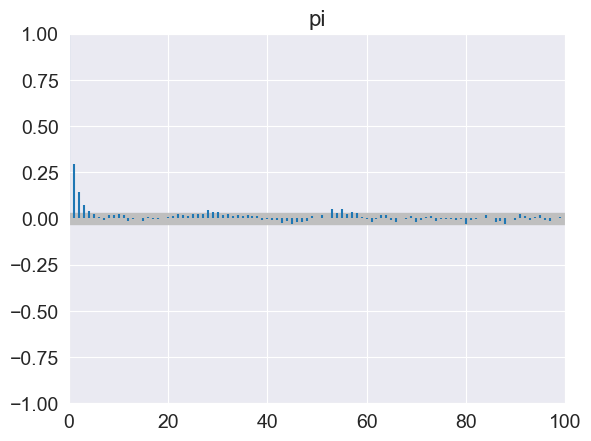

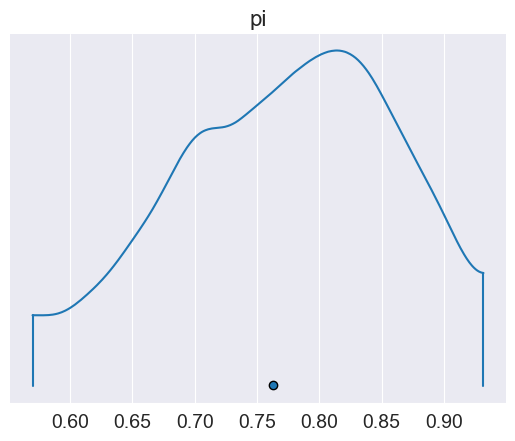

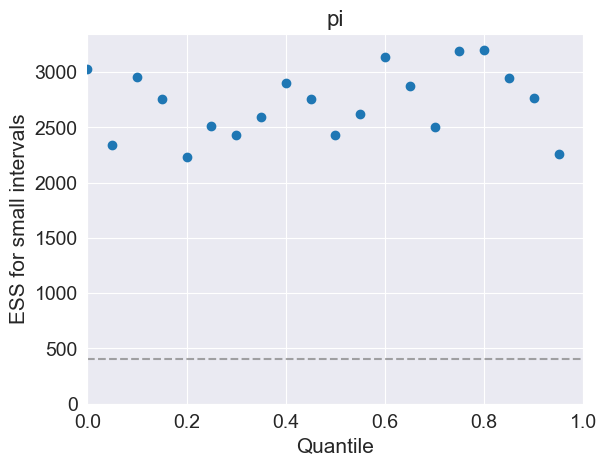

In [22]:
az.plot_trace(trace)
az.plot_autocorr(trace, combined = True)
az.plot_density(trace)
az.plot_ess(trace) # effective sample size

In [23]:
az.rhat(trace)

<xarray.Dataset> Size: 8B
Dimensions:  ()
Data variables:
    pi       float64 8B 1.001

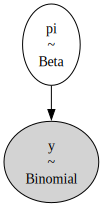

In [24]:
pm.model_to_graphviz(beta_binom_model)

The arrow means that pi follows a binominal distribution.

d)

<Axes: title={'center': 'pi'}, xlabel='Rank (all chains)', ylabel='Chain'>

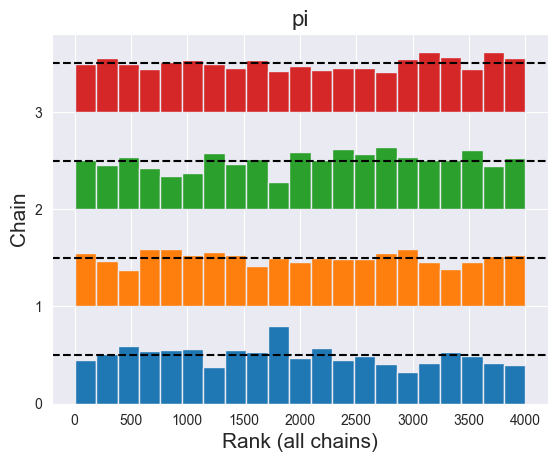

In [25]:
az.plot_rank(trace)

> From the paper: Rank plots are histograms of the ranked posterior draws (ranked over all
> chains) plotted separately for each chain.
> If all of the chains are targeting the same posterior, we expect the ranks in each chain to be
> uniform, whereas if one chain has a different location or scale parameter, this will be
> reflected in the deviation from uniformity. If rank plots of all chains look similar, this
> indicates good mixing of the chains.
>
> This plot was introduced by Aki Vehtari, Andrew Gelman, Daniel Simpson, Bob Carpenter,
> Paul-Christian Burkner (2021): Rank-normalization, folding, and localization:
> An improved R-hat for assessing convergence of MCMC. Bayesian analysis, 16(2):667-718.

The rank plot looks good for our simulation here.

array([[<Axes: title={'center': 'pi'}>, <Axes: title={'center': 'pi'}>]],
      dtype=object)

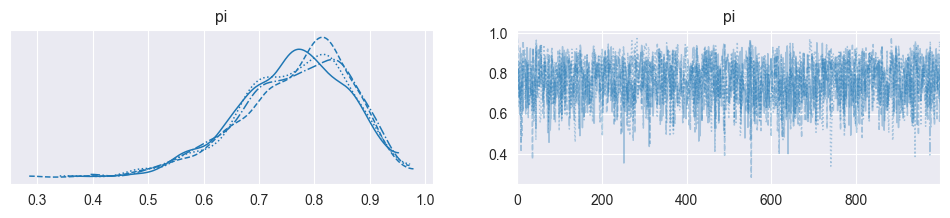

In [26]:
az.plot_trace(trace)

e)

1. In probability and statistics, the truncated normal distribution is the probability distribution derived from that of a normally distributed random variable by bounding the random variable from either below or above (or both). The truncated normal distribution has wide applications in statistics and econometrics.

https://en.wikipedia.org/wiki/Truncated_normal_distribution

<Axes: title={'center': 'Truncated normal distribution'}>

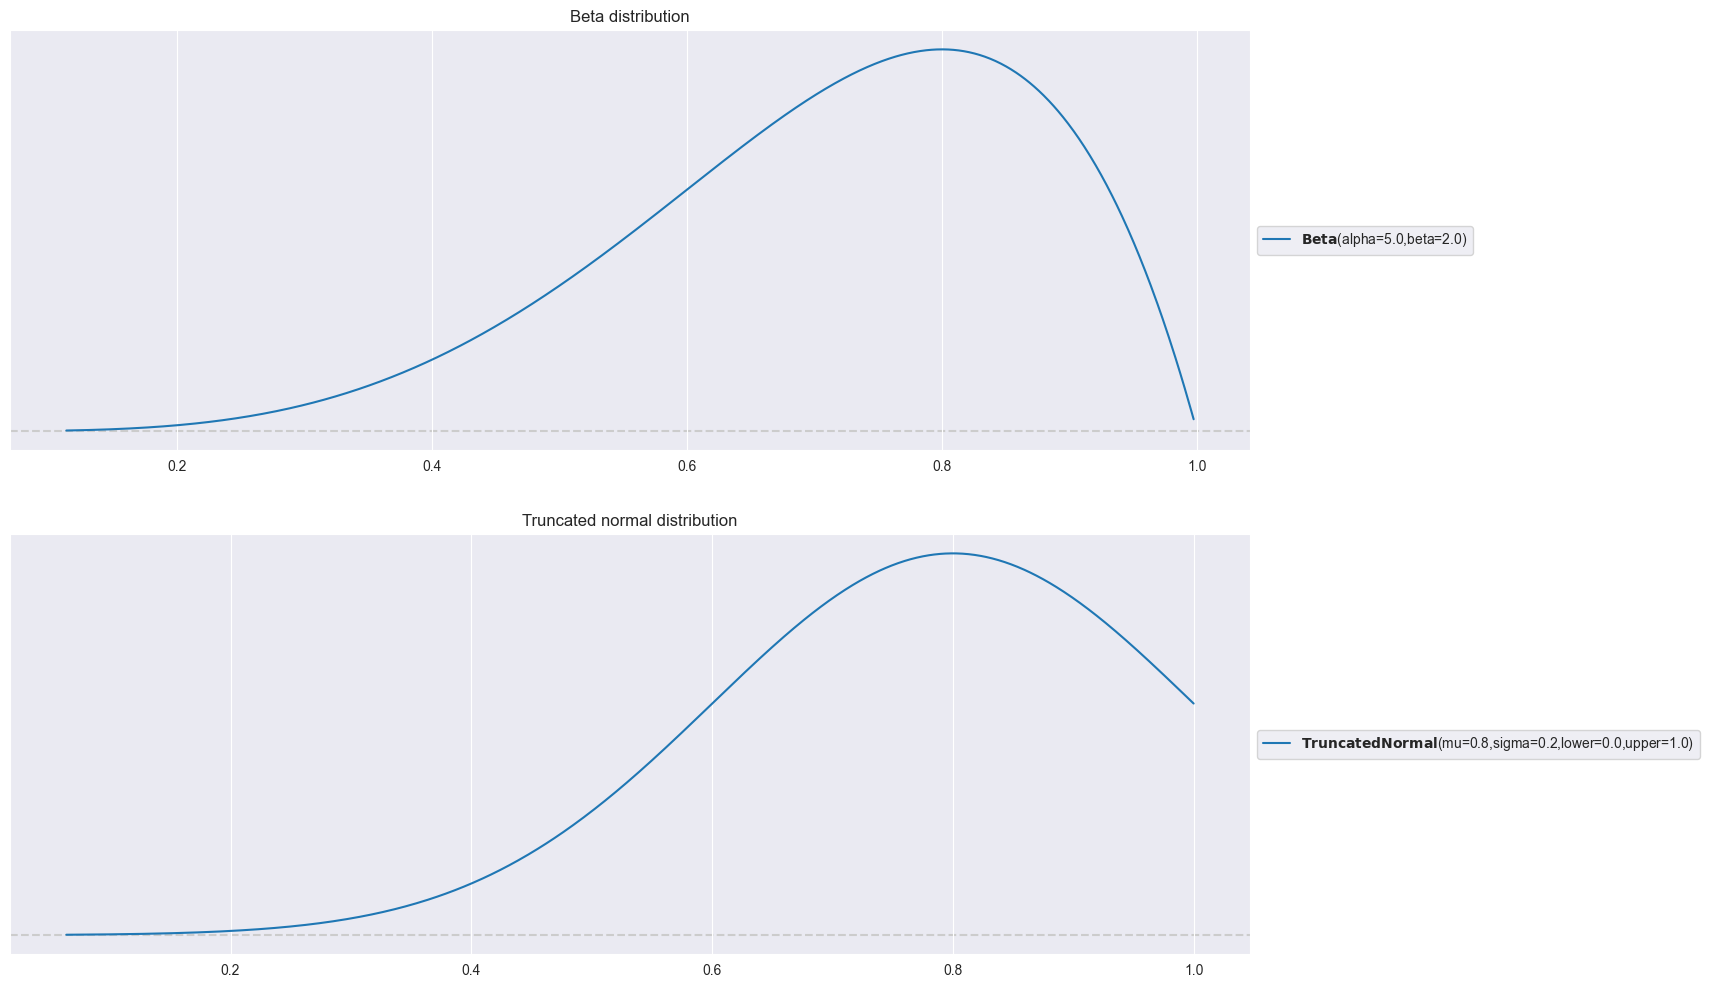

In [27]:
import preliz as pz

fig = plt.figure(figsize = (16, 12))

ax = fig.add_subplot(2, 1, 1)
ax.set_title("Beta distribution")
pz.Beta(alpha, beta).plot_pdf(ax = ax)

ax = fig.add_subplot(2, 1, 2)
ax.set_title("Truncated normal distribution")
pz.TruncatedNormal(mu = 0.8, sigma = 0.2, upper = 1, lower = 0).plot_pdf(ax = ax)

From a first look, both distribution seem to be pretty similar.

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi]


/Users/marbetschar/Development/marbetschar/notes/.venv/lib/python3.9/site-packages/pytensor/scalar/basic.py:2006: RuntimeWarning: invalid value encountered in divide
  return x / y
/Users/marbetschar/Development/marbetschar/notes/.venv/lib/python3.9/site-packages/pytensor/scalar/basic.py:2006: RuntimeWarning: invalid value encountered in divide
  return x / y
Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [pi]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 1 seconds.


<Axes: title={'center': 'pi'}>

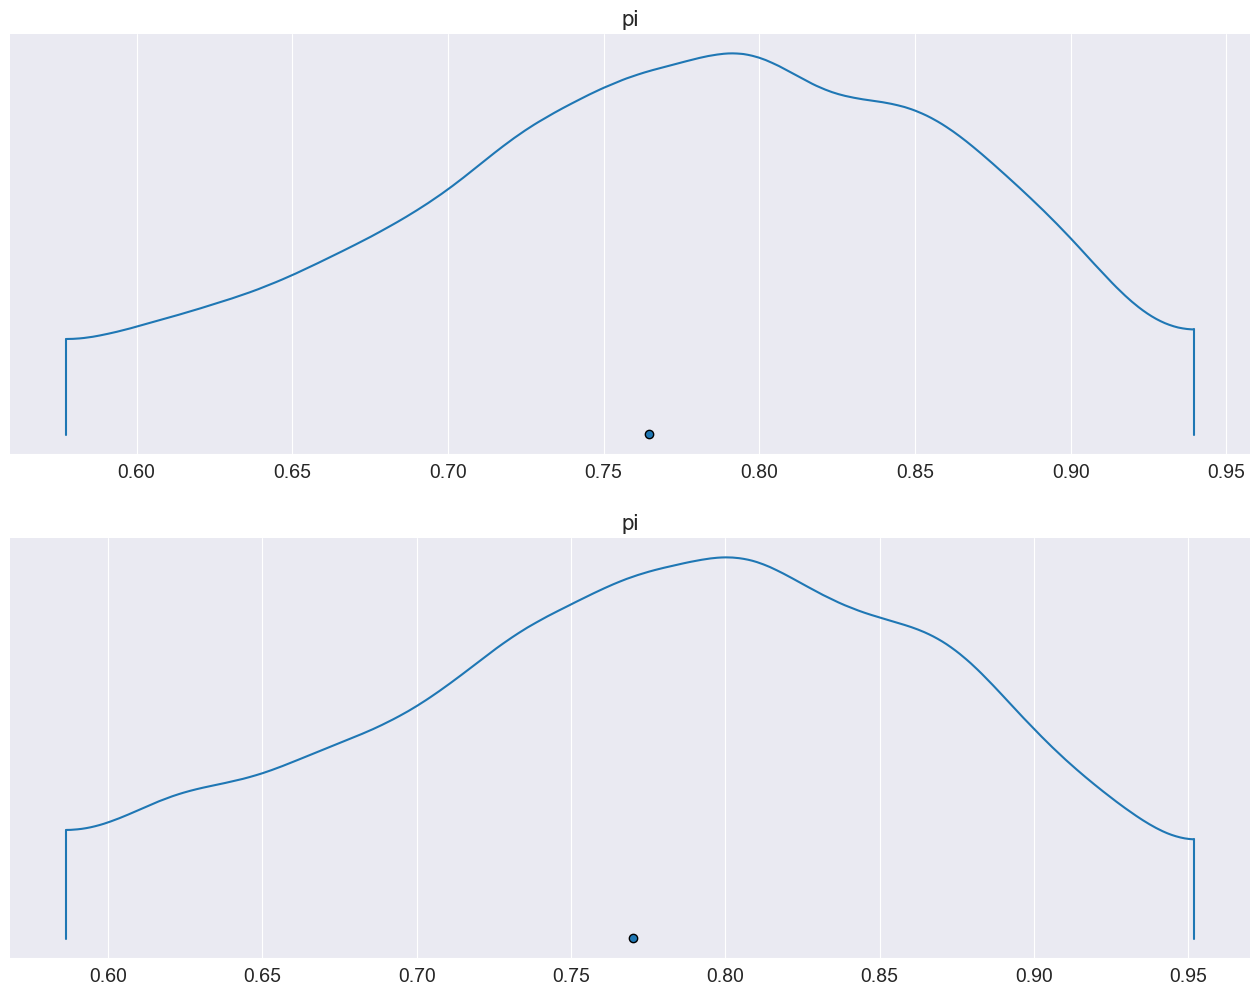

In [28]:
with pm.Model() as beta_binom_model:
    pi = pm.Beta('pi', alpha=alpha, beta=beta)
    y = pm.Binomial('y', n=n, p=pi, observed=k)
    beta_binominal_trace = pm.sample(1000)

with pm.Model() as trunc_normal_binom_model:
    pi = pm.TruncatedNormal('pi', mu=0.8, sigma=0.2, lower=0, upper=1)
    y = pm.Binomial('y', n=n, p=pi, observed=k)
    trunc_normal_binominal_trace = pm.sample(1000)

fig = plt.figure(figsize = (16, 12))

ax = fig.add_subplot(2, 1, 1)
ax.set_title("Beta Binominal Model Density")
az.plot_density(beta_binominal_trace, ax=ax)

ax = fig.add_subplot(2, 1, 2)
ax.set_title("Truncated Normal Binominal Model Density")
az.plot_density(trunc_normal_binominal_trace, ax=ax)

Both density plots look very similar.

In [29]:
az.summary(beta_binominal_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi,0.765,0.101,0.577,0.94,0.002,0.002,1638.0,1964.0,1.0


In [30]:
az.summary(trunc_normal_binominal_trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
pi,0.77,0.102,0.586,0.952,0.003,0.002,1537.0,1800.0,1.0


## The Two Types
### `ess_bulk` - Bulk ESS
- Measures effective sample size for the **center/bulk** of the distribution (around the median)
- Tells you how well you're sampling the main body of the posterior
- **Most important for point estimates** (mean, median)

### `ess_tail` - Tail ESS
- Measures effective sample size for the **tails** of the distribution (extreme values)
- Tells you how well you're sampling rare/extreme events
- **Important for credible intervals** and tail probabilities
- Usually lower than `ess_bulk` because tails are visited less often

## Rule of Thumb
- **Good**: ESS > 400 per chain (for 4 chains, total ESS > 1600)
- **Acceptable**: ESS > 100 per chain
- **Poor**: ESS < 100 per chain - indicates high autocorrelation, need more samples


# Exercise 4

<Axes: title={'center': 'Exponential distribution'}>

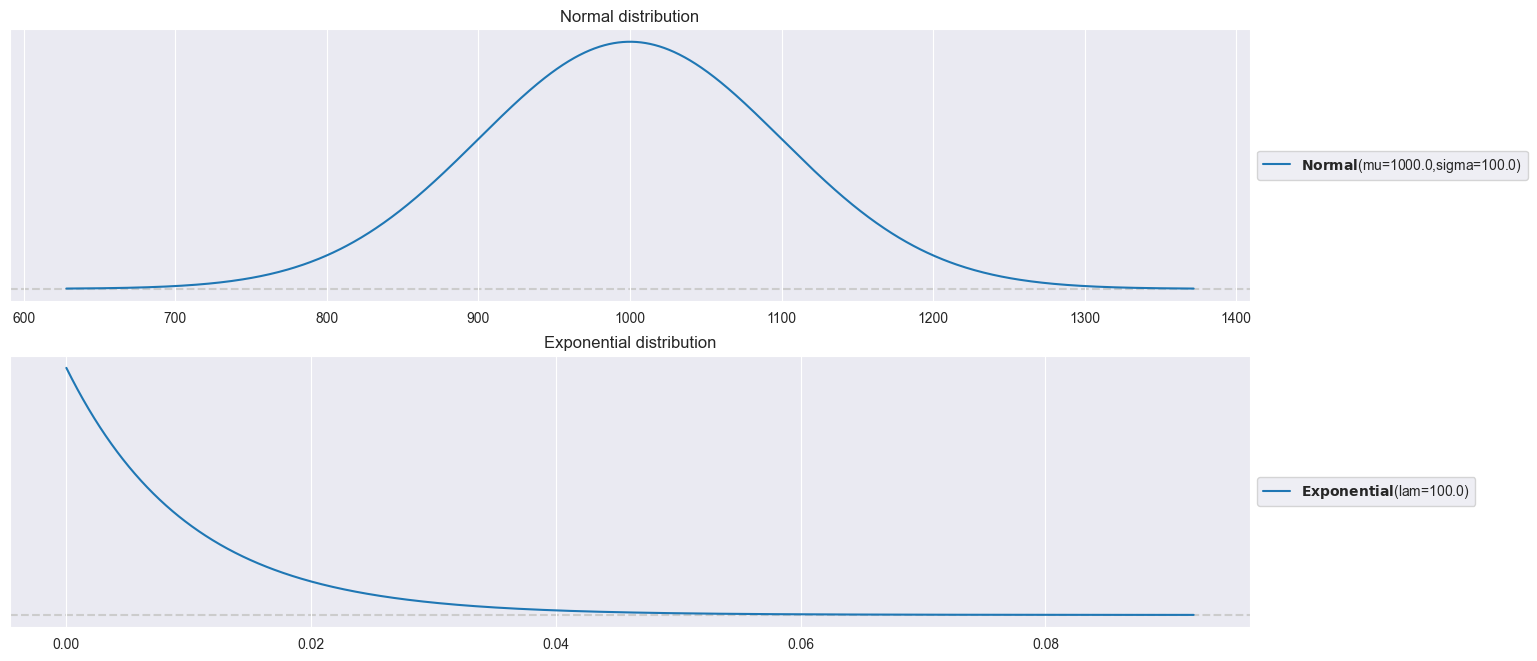

In [31]:
import preliz as pz

fig = plt.figure(figsize = (16, 12))

ax = fig.add_subplot(3, 1, 1)
ax.set_title("Normal distribution")
pz.Normal(1000, 100).plot_pdf(ax = ax)

ax = fig.add_subplot(3, 1, 2)
ax.set_title("Exponential distribution")
pz.Exponential(lam = 100).plot_pdf(ax = ax)


a) The parameter $\lambda$ in an exponential distribution is the rate parameter: It describes how many times of an event happen on average within one time interval. That said, the exponential distribution is used to describe a poisson process - and therefore not a good fit for binominal problems (i.e. it cannot be replaced by a beta distribution).

The exponential distribution favors lower values. Adding the context from above it probably does so, because it becomes increasingly more unlikely for the same event to happen more and more within the same amount of time.

The $\sigma$ in our exercise models the standard deviation from the (assumed) normally distributed average maximum temperature which destroys a container. It is reasonabe to assume that the likeliness of the effective standard deviation decreases the further we wander off from the measurements.

b)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]


/Users/marbetschar/Development/marbetschar/notes/.venv/lib/python3.9/site-packages/pytensor/scalar/basic.py:3100: RuntimeWarning: overflow encountered in exp
  return np.exp(x)
/Users/marbetschar/Development/marbetschar/notes/.venv/lib/python3.9/site-packages/pytensor/scalar/basic.py:3100: RuntimeWarning: overflow encountered in exp
  return np.exp(x)
/Users/marbetschar/Development/marbetschar/notes/.venv/lib/python3.9/site-packages/pytensor/scalar/basic.py:3100: RuntimeWarning: overflow encountered in exp
  return np.exp(x)
/Users/marbetschar/Development/marbetschar/notes/.venv/lib/python3.9/site-packages/pytensor/scalar/basic.py:3100: RuntimeWarning: overflow encountered in exp
  return np.exp(x)
/Users/marbetschar/Development/marbetschar/notes/.venv/lib/python3.9/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
/Users/marbetschar/Development/marbetschar/notes/.venv/lib/python3.9

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,1047.902,2.377,1043.525,1052.403,0.037,0.026,4041.0,3233.0,1.0
sigma,7.654,0.160,7.355,7.953,0.003,0.002,4032.0,2938.0,1.0


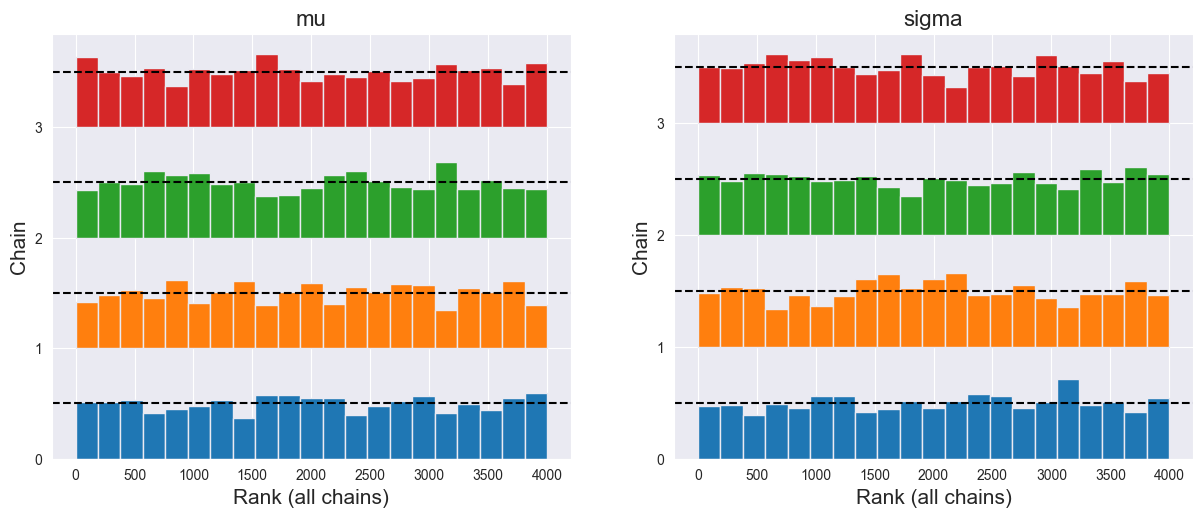

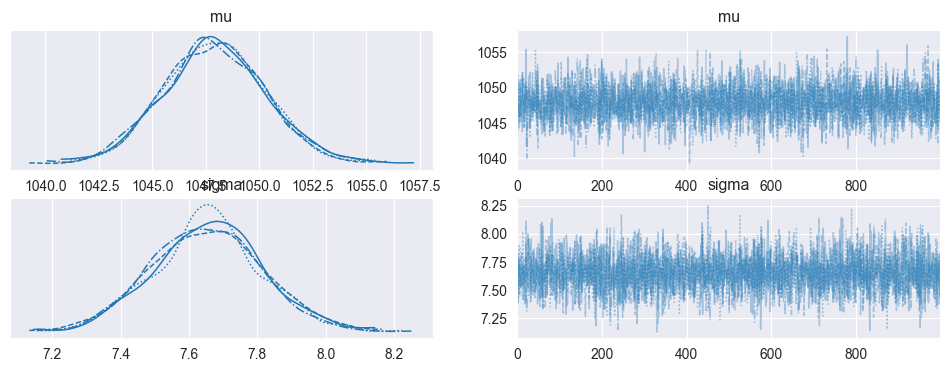

In [32]:
import pymc as pm
import arviz as az

# Disable C compilation by using the Python-only mode:
import pytensor
pytensor.config.cxx = ""

with pm.Model() as model:
    mu = pm.Normal('mu', mu=1000, sigma=100)
    sigma = pm.Exponential('sigma', lam=100)
    y = pm.Normal('y', mu=mu, sigma=sigma, observed=[1055,1053,1226,967,980,1049,1040,1051,1002,1057])
    samples = pm.sample(1000)

az.plot_rank(samples)
az.plot_trace(samples)
az.summary(samples)

c)

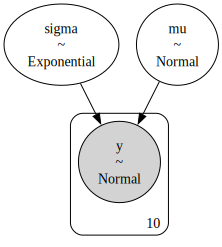

In [33]:
pm.model_to_graphviz(model)

# Explanation of the Graphical Model

This diagram is a **probabilistic graphical model** (a *plate diagram*).

## Components

### 1. Nodes (random variables)
- **$ \sigma \sim \text{Exponential} $**
  - $ \sigma $ is drawn from an exponential distribution.
  - This serves as the **scale parameter** (standard deviation) for the normal distribution below.

- **$ \mu \sim \mathcal{N} $**
  - $ \mu $ is drawn from a normal distribution.
  - This serves as the **mean** for the normal distribution below.

- **$ y \sim \mathcal{N} $** (grey circle)
  - Observed or latent data values $ y $.
  - These follow a normal distribution with parameters $ \mu $ (mean) and $ \sigma $ (standard deviation).

### 2. Arrows (dependencies)
- Arrows from $ \sigma $ and $ \mu $ into $ y $ mean: $y \mid \mu, \sigma \sim \mathcal{N}(\mu, \sigma)$

### 3. Plate (box with "10")
- The rectangle enclosing $ y $ with the number **10** indicates **replication**.
- There are **10 independent samples** of $ y $, each drawn from the same distribution: $y_1, y_2, \dots, y_{10} \;\; \overset{iid}{\sim} \; \mathcal{N}(\mu, \sigma)$

### 4. Shading of y
- Shaded nodes usually represent **observed data**.
- Thus the 10 values of $ y $ are observed data points.
- The parameters $ \mu $ and $ \sigma $ are **latent** (unobserved).

## Full Model Summary

This is a **hierarchical Bayesian model**:

- Prior on $ \sigma $: $\sigma \sim \text{Exponential}(\lambda)$
- Prior on $ \mu $: $\mu \sim \mathcal{N}(\mu_0, \tau^2)$
- Likelihood: for $ i = 1, \dots, 10 $: $y_i \sim \mathcal{N}(\mu, \sigma)$

Where:
- $ \mu_0 $, $ \tau^2 $, and $ \lambda $ are hyperparameters (not shown in the diagram).
- The goal is typically to infer the **posterior distribution** of $ \mu $ and $ \sigma $ given the observed data $ y_1, \dots, y_{10} $.

d)

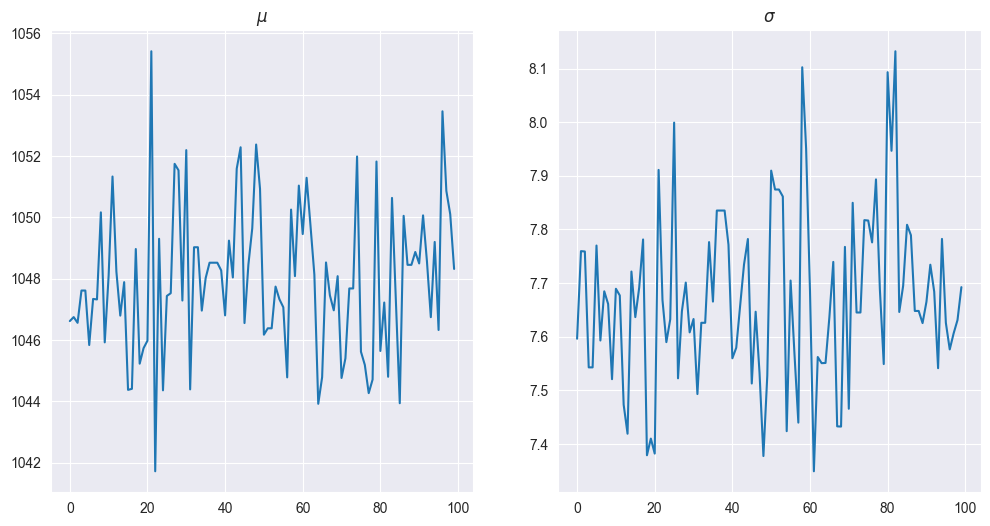

In [34]:
mus = samples.posterior['mu'][0:1, 0:100]
sigmas = samples.posterior['sigma'][0:1, 0:100]

fig = plt.figure(figsize = (12, 6))

ax = fig.add_subplot(1, 2, 1)
ax.set_title("$\mu$")
for mu in mus:
    ax.plot(mu)

ax = fig.add_subplot(1, 2, 2)
ax.set_title("$\sigma$")
for sigma in sigmas:
    ax.plot(sigma)


For $\mu$ there seems to be a warm-up phase in the very beginning. But it is not obvious, because later on in the chain we have similar values - so it could be coincidence.

Text(0, 0.5, '$\\sigma$')

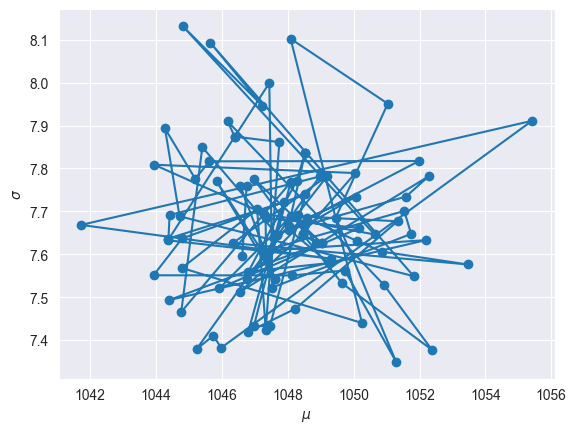

In [35]:
plt.plot(samples.posterior['mu'][0, :100], samples.posterior['sigma'][0, :100], marker="o" )
plt.xlabel("$\mu$")
plt.ylabel("$\sigma$")